# **Sentiment analysis of Tweets using Machine learning**

Cristobal Medina Meza

Data from: https://www.kaggle.com/datasets/kazanova/sentiment140?resource=download

Made with help from this tutorial: https://www.youtube.com/watch?v=lMQzEk5vht4

model_Evaluate function from: https://www.kaggle.com/code/baorbaor/eda-sentiment-analysis#RNN-



# Import libraries

In [1]:
# Import libraries
# Data manipulation

import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

# Methods and stopwords text procesing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('punkt')
nltk.download('wordnet')


# Machine learning libraries

from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#English Stopwords

In [2]:
# creating a stopwords set

import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Load the dataset

In [3]:
# Load the dataset in colab
def load_dataset(filepath, cols):
  """
  reads the csv file to return
  a dataframe with specified column names
  """

  df = pd.read_csv(filepath, encoding = 'latin-1')
  df.columns = cols
  return df

  # Data was extracted from https://www.kaggle.com/datasets/kazanova/sentiment140?resource=download

#Preprocess the tweets.



In [5]:
#Here we download the necessary packages



def preprocess_tweet_text(tweet):
  """
  Runs a set of transformational steps to preprocess the text of the tweet
  """

  urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
  userPattern = '@[^\s]+'

  #Lower casing
  tweet = tweet.lower()
  tweet=tweet[1:]

  #Remove urls
  tweet = re.sub(urlPattern,'',tweet)


  #Remove punctuations
  tweet = tweet.translate(str.maketrans("","",string.punctuation))

  #Remove # & @
  tweet = re.sub(userPattern,'', tweet)

  #Remove Stopwords
  tweet_tokens = word_tokenize(tweet)
  filtered_words = [word for word in tweet_tokens if word not in stop_words]

  #Stemming
  ps = PorterStemmer()
  stemmed_words = [ps.stem(w) for w in filtered_words]

  #lemmatizing
  lemmatizer = WordNetLemmatizer()
  lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in stemmed_words]

  return " ".join(lemma_words)


preprocess_tweet_text("Hi there, how are you preparing for your exams?")

'prepar exam'

#Vectorizing tokens

In [6]:
def get_feature_vector(train_fit):
  vector = TfidfVectorizer(sublinear_tf = True)
  vector.fit(train_fit)
  return vector

#**Now, we can start working with the data set**

In [7]:
#Load the dataset
cols = ("target","ids","date","flag","user","tweet")
df = load_dataset('Tweets.csv', cols)

#Replace 4's with ones for better understanding of our data
df["target"] = df["target"].replace(4,1)

#To string
df['tweet'] = df['tweet'].astype('str')

#Preprocessing tweets
df['processed_tweets'] = df['tweet'].apply(lambda x: preprocess_tweet_text(x))

In [8]:
df.head(10)

,target,ids,date,flag,user,tweet,processed_tweets
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset cant updat facebook text might cri resul...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save 50 res...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behav im mad cant see
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew,kwesidei whole crew
5,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug,eed hug
6,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...,loltrish hey long time see ye rain bit bit lol...
7,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it,tatianak nope didnt
8,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?,twittera que muera
9,0,1467812416,Mon Apr 06 22:20:16 PDT 2009,NO_QUERY,erinx3leannexo,spring break in plain city... it's snowing,pring break plain citi snow


In [9]:
#We drop the unwanted colums
df.drop(["date","flag","user"], axis=1, inplace=True)
df.drop("ids", axis=1, inplace=True)

In [10]:
df.head(10)

,target,tweet,processed_tweets
0,0,is upset that he can't update his Facebook by ...,upset cant updat facebook text might cri resul...
1,0,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save 50 res...
2,0,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
3,0,"@nationwideclass no, it's not behaving at all....",nationwideclass behav im mad cant see
4,0,@Kwesidei not the whole crew,kwesidei whole crew
5,0,Need a hug,eed hug
6,0,@LOLTrish hey long time no see! Yes.. Rains a...,loltrish hey long time see ye rain bit bit lol...
7,0,@Tatiana_K nope they didn't have it,tatianak nope didnt
8,0,@twittera que me muera ?,twittera que muera
9,0,spring break in plain city... it's snowing,pring break plain citi snow


In [11]:
#Checking if any null values present
(df.isnull().sum() / len(df))*100

target              0.0
tweet               0.0
processed_tweets    0.0
dtype: float64

#Analyzing the df
Word-Cloud for Negative tweets.


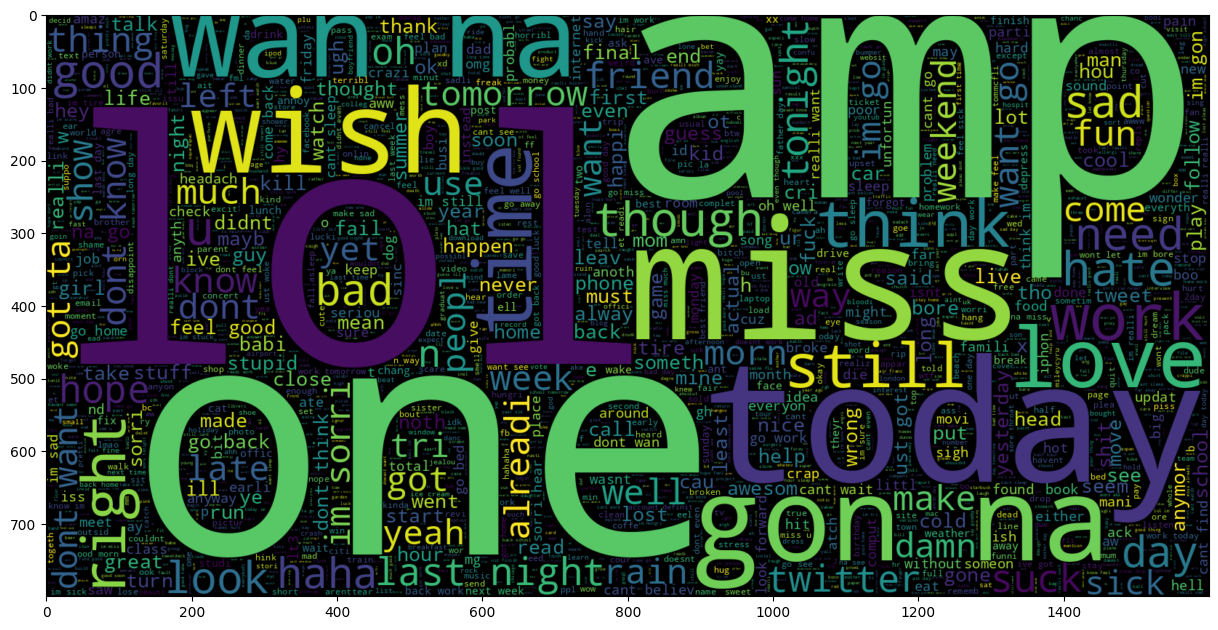

In [12]:
from wordcloud import WordCloud

#Diagram 1
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.target == 0].processed_tweets))
plt.imshow(wc , interpolation = 'bilinear')

Word-Cloud for Positive tweets

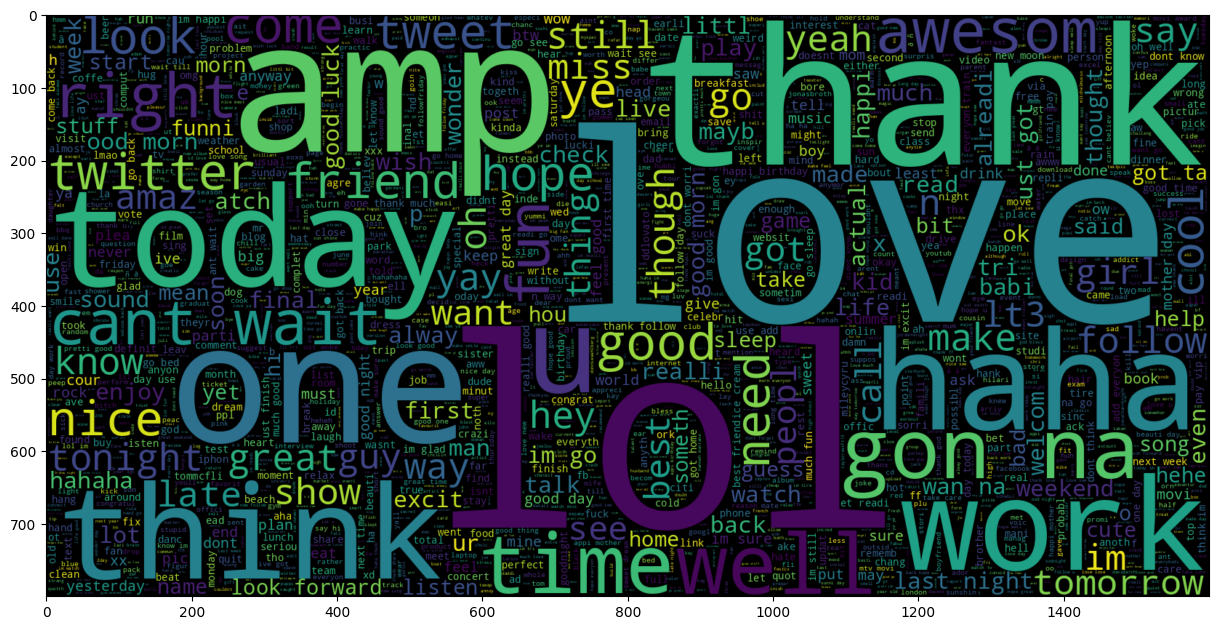

In [13]:
#Diagram 2
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.target == 1].processed_tweets))
plt.imshow(wc , interpolation = 'bilinear')

In [14]:
#Assign values to X & y for the regression models
X = df['processed_tweets'].values
y = df['target'].values

In [15]:
print(X.shape)
print(y.shape)

(1599999,)
(1599999,)


In [16]:
#Convert a collection of raw documents to a matrix of TF-IDF features.
vector = TfidfVectorizer(sublinear_tf=True)
X = vector.fit_transform(X)
print(f'Vector fitted.')

Vector fitted.


In [17]:
#Divide the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=101)

In [18]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print()
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (1279999, 740295)
y_train (1279999,)

X_test (320000, 740295)
y_test (320000,)


In [19]:
#Function for evaluating the model
def model_Evaluate(model):
  #accuracy of model on training data
  acc_train=model.score(X_train, y_train)
  #accuracy of model on test data
  acc_test=model.score(X_test, y_test)

  print('Accuracy of model on training data : {}'.format(acc_train*100))
  print('Accuracy of model on testing data : {} \n'.format(acc_test*100))

  # Predict values for Test dataset
  y_pred = model.predict(X_test)

  # Print the evaluation metrics for the dataset.
  print(classification_report(y_test, y_pred))

  # Compute and plot the Confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)

  categories  = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)

  sns.heatmap(cf_matrix, annot = labels, cmap = 'Reds',fmt = '',
              xticklabels = categories, yticklabels = categories)

  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

#**Final results:**

Logistic regression

Accuracy of model on training data : 80.29381272954119
Accuracy of model on testing data : 77.91843750000001 

              precision    recall  f1-score   support

           0       0.79      0.76      0.77    159763
           1       0.77      0.80      0.78    160237

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



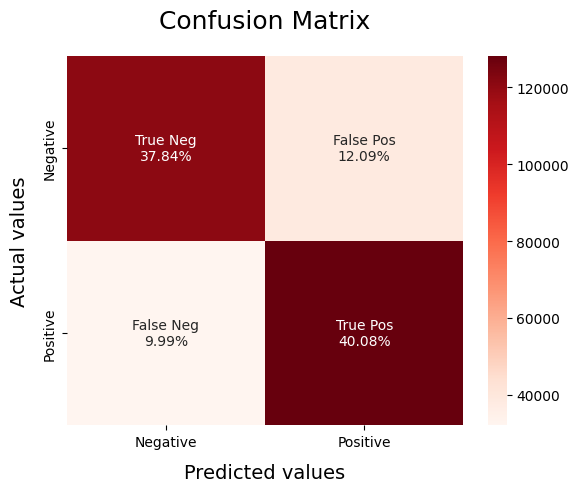

In [20]:
lr = LogisticRegression()
history=lr.fit(X_train, y_train)
model_Evaluate(lr)

In [25]:
print(lr.coef_, lr.intercept_)

[[ 0.88105718 -0.3799774  -0.53675773 ...  0.06478558  0.02716256
   0.08831542]] [0.53269035]


Linear svm

Accuracy of model on training data : 88.63530362133095
Accuracy of model on testing data : 77.28031250000001 

              precision    recall  f1-score   support

           0       0.78      0.76      0.77    159763
           1       0.77      0.79      0.78    160237

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



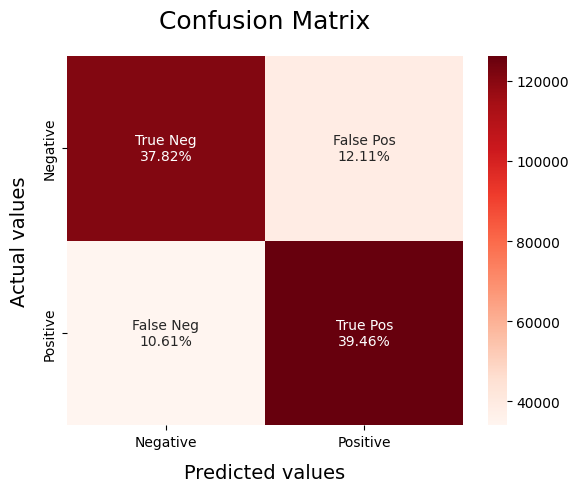

In [21]:
svc = LinearSVC()
svc.fit(X_train, y_train)
model_Evaluate(svc)

In [26]:
print(svc.coef_, svc.intercept_)

[[ 0.2815214  -0.03710374 -0.42315514 ...  0.15580592 -0.14224387
   0.36321337]] [0.1885389]


Random Forest

Accuracy of model on training data : 71.08638366123724
Accuracy of model on testing data : 69.6765625 

              precision    recall  f1-score   support

           0       0.72      0.65      0.68    159763
           1       0.68      0.75      0.71    160237

    accuracy                           0.70    320000
   macro avg       0.70      0.70      0.70    320000
weighted avg       0.70      0.70      0.70    320000



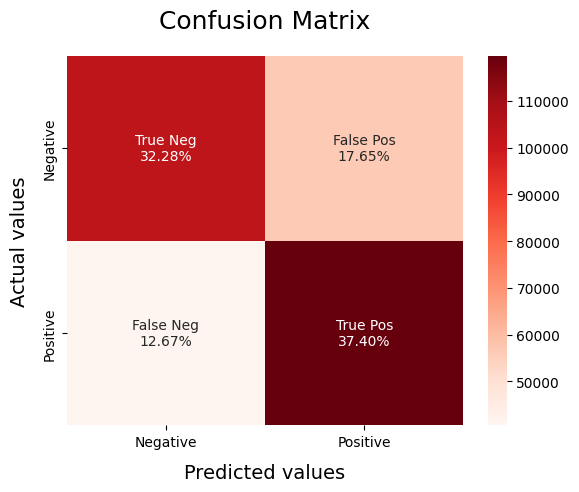

In [22]:
rf = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', max_depth=50)
rf.fit(X_train, y_train)
model_Evaluate(rf)

In [28]:
print(rf.feature_importances_)

[0. 0. 0. ... 0. 0. 0.]


Naive Bayes

Accuracy of model on training data : 83.39733077916466
Accuracy of model on testing data : 76.8803125 

              precision    recall  f1-score   support

           0       0.76      0.79      0.77    159763
           1       0.78      0.75      0.76    160237

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



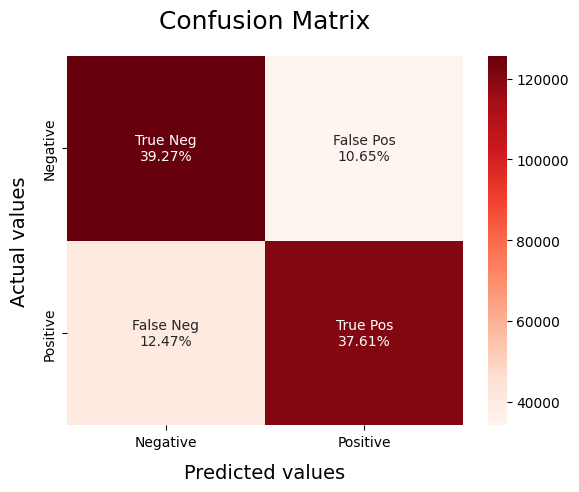

In [23]:
nb = BernoulliNB()
nb.fit(X_train, y_train)
model_Evaluate(nb)